<a href="https://colab.research.google.com/github/parsa-abbasi/Sentiment-Analysis/blob/master/Binary-Classification/DL_KerasEmb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

## Install required libraries

In [1]:
!pip install hazm
!pip install stopwords_guilannlp
!pip install matplotlib==3.1.0

## Import Libraries

In [2]:
# General
import numpy as np
import pandas as pd
import codecs
from google.colab import files
# Keras
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Preprocessing
from stopwords_guilannlp import stopwords_output
from hazm import *
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils import plot_model
# Measuring metrics
from sklearn.metrics import f1_score

Using TensorFlow backend.


# Upload dataset files

Upload dataset files to colab environment

You can access to dataset files through following links:

(x_train, x_test, y_train, y_test)
- [Original dataset](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Original)
- [Balanced with extra data](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/BalancedWithExtra)
- [Data Augmentation - Full Translate](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/FullTranslate)
- [Data Augmentation - Synonyms](https://github.com/parsa-abbasi/Sentiment-Analysis/tree/master/Dataset/Synonyms)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving x_test.csv to x_test.csv
Saving x_train.csv to x_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv



# Import & Analyze Dataset

In [0]:
x_train = pd.read_csv('x_train.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
x_test = pd.read_csv('x_test.csv', sep='\t', index_col=None, header=None, encoding="utf-8")[1]
y_train = pd.read_csv('y_train.csv', sep='\t', index_col=None, header=None)[1]
y_test = pd.read_csv('y_test.csv', sep='\t', index_col=None, header=None)[1]

In [0]:
# The dataset csv files created using old version of Pandas
# so we need to do some additional preparation
x_train = x_train[1:]
x_train = x_train.reset_index(drop=True)
x_test = x_test[1:]
x_test = x_test.reset_index(drop=True)
y_train = y_train[1:]
y_train = y_train.reset_index(drop=True)
y_test = y_test[1:]
y_test = y_test.reset_index(drop=True)

In [6]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of training sentence:  (5561,)
Number of training label:  (5561,)
Number of testing sentence:  (1854,)
Number of testing label:  (1854,)


Remove *neutral* sentences from the dataset

In [0]:
binary_y_train = []
binary_y_test = []
binary_x_train = []
binary_x_test = []
for i, y in enumerate(y_train):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_train.append(1)
      binary_x_train.append(x_train[i])
    else:
      binary_y_train.append(0)
      binary_x_train.append(x_train[i])
      
for i, y in enumerate(y_test):
  if int(y) != 0:
    if int(y) > 0:
      binary_y_test.append(1)
      binary_x_test.append(x_test[i])
    else:
      binary_y_test.append(0)
      binary_x_test.append(x_test[i])

In [0]:
# Convert dataframes to numpy arrays
x_train = np.asarray(binary_x_train)
x_test = np.asarray(binary_x_test)
y_train = np.asarray(binary_y_train)
y_test = np.asarray(binary_y_test)

In [9]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{1: 2611, 0: 541}


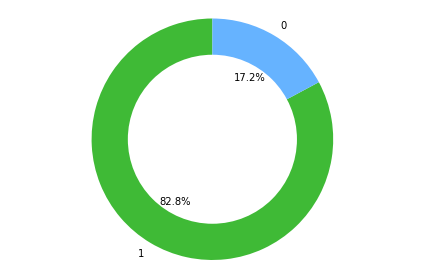

In [10]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('balanced_with_extra_binary.png')
plt.show()

In [0]:
# Decomment following line if you want to download dataset figure
# files.download('balanced_with_extra_binary.png')

(0, 5000)

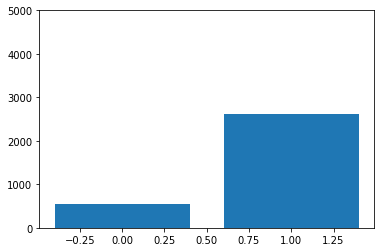

In [12]:
plt.bar(labels[::-1], sizes[::-1], width=0.8, bottom=None, align='center')
plt.ylim([0, 5000])
# plt.savefig('bar_balanced_with_extra_binary.png')

In [0]:
# Decomment following line if you want to download dataset figure
# files.download('bar_balanced_with_extra_binary.png')

# Preprocess

In [0]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

# Prepare data for Deep Learning model

## Apply preprocessing to data

In [0]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [0]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

## Setting tokenizer up

In [0]:
num_words = 2500

# Create the tokenizer
tokenizer = Tokenizer()

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [0]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])

## Embed sentences

In [0]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [0]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)

In [0]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Deep Learning Models

## B-LSTM Model

In [0]:
model_blstm = Sequential()
model_blstm.add(Embedding(vocab_size, 300, input_length=max_length))
model_blstm.add(Bidirectional(CuDNNLSTM(300, return_sequences=True, name='lstm_layer')))
model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(1, activation='sigmoid'))

In [108]:
model_blstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 7

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 297, 300)          1588500   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 297, 600)          1444800   
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 600)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_20 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)               

In [109]:
# Train model
hist_blstm = model_blstm.fit(x_train_padded, y_train, batch_size=batch_size_blstm, epochs=epochs_blstm)

Epoch 1/7
3152/3152 [==============================] - 13s 4ms/step - loss: 0.4579 - acc: 0.8195
Epoch 2/7
3152/3152 [==============================] - 11s 3ms/step - loss: 0.2877 - acc: 0.8677
Epoch 3/7
3152/3152 [==============================] - 11s 3ms/step - loss: 0.1680 - acc: 0.9369
Epoch 4/7
3152/3152 [==============================] - 11s 3ms/step - loss: 0.0819 - acc: 0.9718
Epoch 5/7
3152/3152 [==============================] - 11s 3ms/step - loss: 0.0390 - acc: 0.9860
Epoch 6/7
3152/3152 [==============================] - 11s 3ms/step - loss: 0.0165 - acc: 0.9946
Epoch 7/7
3152/3152 [==============================] - 11s 3ms/step - loss: 0.0098 - acc: 0.9971


In [110]:
# Evaluate model
loss_blstm, acc_blstm = model_blstm.evaluate(x_test_padded, y_test, verbose=0)
print('Test Accuracy: %f' % (acc_blstm*100))

Test Accuracy: 86.318632


In [0]:
# Get prediction label
y_pred_blstm = model_blstm.predict_classes(x_test_padded[:-1])

## CNN Model

In [0]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 300, input_length=max_length))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(500, activation="sigmoid"))
model_cnn.add(Dense(1, activation='sigmoid'))

In [71]:
model_cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 10

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 297, 300)          1588500   
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 297, 64)           76864     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 148, 64)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 148, 64)           32832     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 74, 64)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 74, 64)            65600     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)               

In [72]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, y_train, batch_size=batch_size_cnn, epochs=epochs_cnn)

Epoch 1/10
3152/3152 [==============================] - 3s 857us/step - loss: 0.4883 - acc: 0.7903
Epoch 2/10
3152/3152 [==============================] - 1s 389us/step - loss: 0.3412 - acc: 0.8484
Epoch 3/10
3152/3152 [==============================] - 1s 385us/step - loss: 0.1657 - acc: 0.9388
Epoch 4/10
3152/3152 [==============================] - 1s 382us/step - loss: 0.0775 - acc: 0.9746
Epoch 5/10
3152/3152 [==============================] - 1s 383us/step - loss: 0.0360 - acc: 0.9908
Epoch 6/10
3152/3152 [==============================] - 1s 383us/step - loss: 0.0217 - acc: 0.9937
Epoch 7/10
3152/3152 [==============================] - 1s 387us/step - loss: 0.0109 - acc: 0.9984
Epoch 8/10
3152/3152 [==============================] - 1s 388us/step - loss: 0.0079 - acc: 0.9987
Epoch 9/10
3152/3152 [==============================] - 1s 384us/step - loss: 0.0083 - acc: 0.9984
Epoch 10/10
3152/3152 [==============================] - 1s 387us/step - loss: 0.0059 - acc: 0.9990


In [73]:
# Evaluate model
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 85.868587


In [0]:
# Get prediction label
y_pred_cnn = model_cnn.predict_classes(x_test_padded[:-1])

# Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = np.array([0, 1])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 98  98]
 [ 54 860]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.5  0.5 ]
 [0.06 0.94]]
AxesImage(54,36;334.8x217.44)


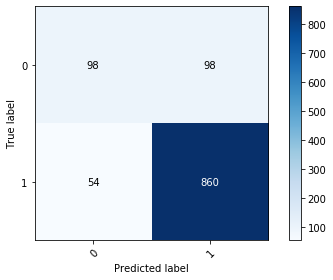

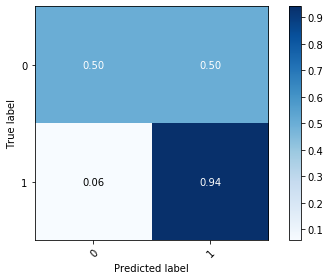

In [113]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test[:-1], y_pred_blstm, classes=class_names)
plt.savefig('cm-blstm.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test[:-1], y_pred_blstm, classes=class_names, normalize=True)
# Decomment following line if you want to save the figure
plt.savefig('cm-blstm-normalized.png')
plt.show()

In [0]:
# Decomment following line if you want to download confusion matrix figure
# files.download('cm-blstm.png')
# files.download('cm-blstm-normalized.png')

Confusion matrix, without normalization
[[104  92]
 [ 65 849]]
AxesImage(54,36;334.8x217.44)
Normalized confusion matrix
[[0.53 0.47]
 [0.07 0.93]]
AxesImage(54,36;334.8x217.44)


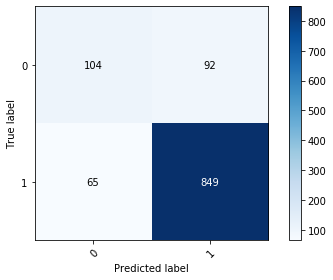

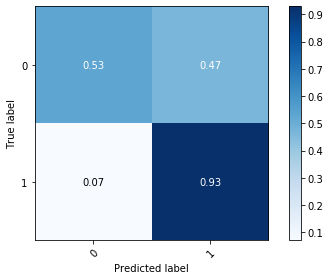

In [115]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test[:-1], y_pred_cnn, classes=class_names)
plt.savefig('cm-cnn.png')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test[:-1], y_pred_cnn, classes=class_names, normalize=True)
plt.savefig('cm-cnn-normalized.png')
plt.show()

In [0]:
# Decomment following line if you want to download confusion matrix figure
# files.download('cm-cnn.png')
# files.download('cm-cnn-normalized.png')

## F1 Score

In [117]:
print("(Weighted) F1 score of KerasEmb B-LSTM model:")
f1_score(y_test[:-1], y_pred_blstm, average='weighted')

(Weighted) F1 score of KerasEmb B-LSTM model:


0.8560154318775008

In [118]:
print("(Micro) F1 score of KerasEmb B-LSTM model:")
f1_score(y_test[:-1], y_pred_blstm, average='micro')

(Micro) F1 score of KerasEmb B-LSTM model:


0.863063063063063

In [119]:
print("(Weighted) F1 score of KerasEmb CNN model:")
f1_score(y_test[:-1], y_pred_cnn, average='weighted')

(Weighted) F1 score of KerasEmb CNN model:


0.8543565209783871

In [120]:
print("(Micro) F1 score of KerasEmb CNN model:")
f1_score(y_test[:-1], y_pred_cnn, average='micro')

(Micro) F1 score of KerasEmb CNN model:


0.8585585585585586

# Model Visualization

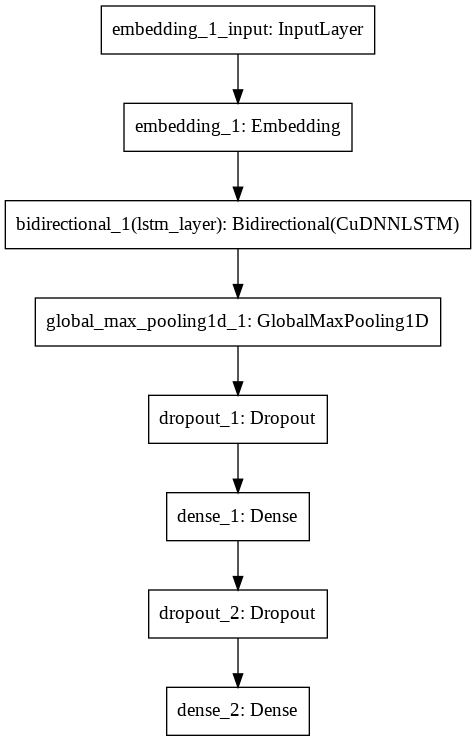

In [0]:
plot_model(model_blstm, to_file='binary-blstm.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('binary-blstm.png')

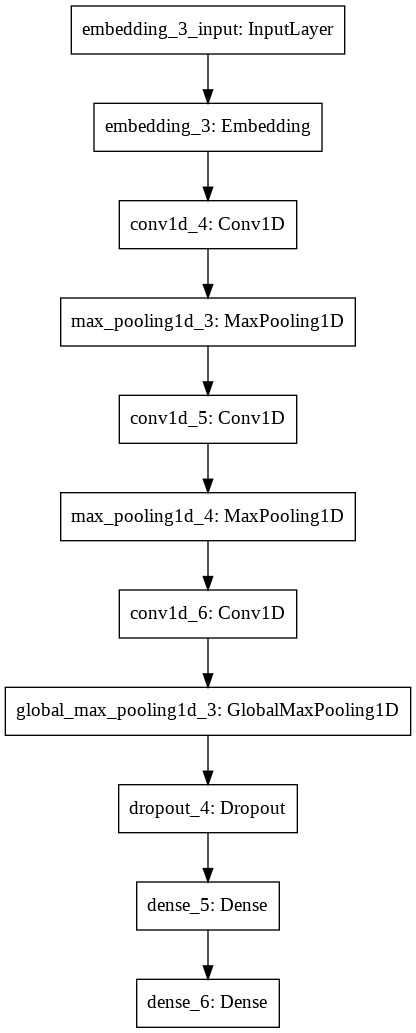

In [0]:
plot_model(model_cnn, to_file='binary-cnn.png')

In [0]:
# Decomment following line if you want to download model figure
# files.download('binary-cnn.png')